# Laborarbeit Künstliche Intelligenz

## Thema :  Bayes Netze und Case Based Reasoning

### Namen des/r Studierenden: 

Niklas Werthmann

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.set_loglevel("warning")

# Einlesen der CSV-Datei
file_path = './bikedata/sampled_data_004.csv'
data = pd.read_csv(file_path, sep=";", decimal=",")

c:\Program Files\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Datenbereinigung

#### Suche nach NaN Werten

In [2]:
print(data.isnull().sum())

Distance           0
Elapsed Time       0
Elevation High     0
Elevation Gain     0
Weekday            0
Bike Type         58
dtype: int64


Wir sehen, dass lediglich der Bike Type bei einigen Daten nicht bekannt ist. Da dies unsere Zielvariable ist, entfernen wir diese Datensätze.

In [3]:
data = data.dropna(subset=['Bike Type'])

## Explorative Datenanalyse

In [4]:
data.head()

,Distance,Elapsed Time,Elevation High,Elevation Gain,Weekday,Bike Type
2,40.27,22875,2279.9,494.11,Saturday,mtb
3,3.23,1233,539.0,21.00,Wednesday,race bike
4,35.40,6199,371.0,157.00,Wednesday,trecking bike
5,65.38,10591,530.2,937.00,Saturday,race bike
6,52.38,7940,615.8,721.00,Saturday,race bike


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189 entries, 2 to 246
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Distance        189 non-null    float64
 1   Elapsed Time    189 non-null    int64  
 2   Elevation High  189 non-null    float64
 3   Elevation Gain  189 non-null    float64
 4   Weekday         189 non-null    object 
 5   Bike Type       189 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 10.3+ KB


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189 entries, 2 to 246
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Distance        189 non-null    float64
 1   Elapsed Time    189 non-null    int64  
 2   Elevation High  189 non-null    float64
 3   Elevation Gain  189 non-null    float64
 4   Weekday         189 non-null    object 
 5   Bike Type       189 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 10.3+ KB


In [7]:
data.describe()

,Distance,Elapsed Time,Elevation High,Elevation Gain
count,189.000000,189.000000,189.000000,189.000000
mean,40.362381,6947.867725,458.780423,412.484603
std,27.906235,5312.384989,322.351340,479.385288
min,3.230000,952.000000,-120.600000,13.800000
25%,28.300000,4697.000000,329.000000,146.000000
50%,35.250000,5666.000000,416.200000,279.000000
75%,41.890000,6810.000000,501.000000,517.000000
max,219.320000,45073.000000,2766.800000,4838.000000


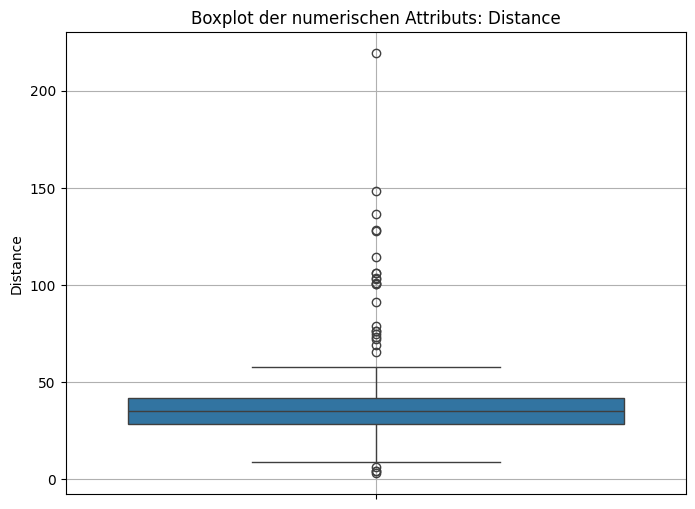

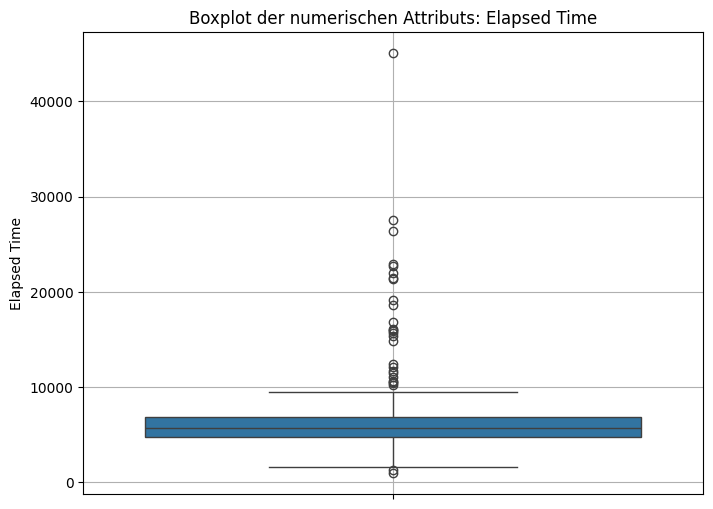

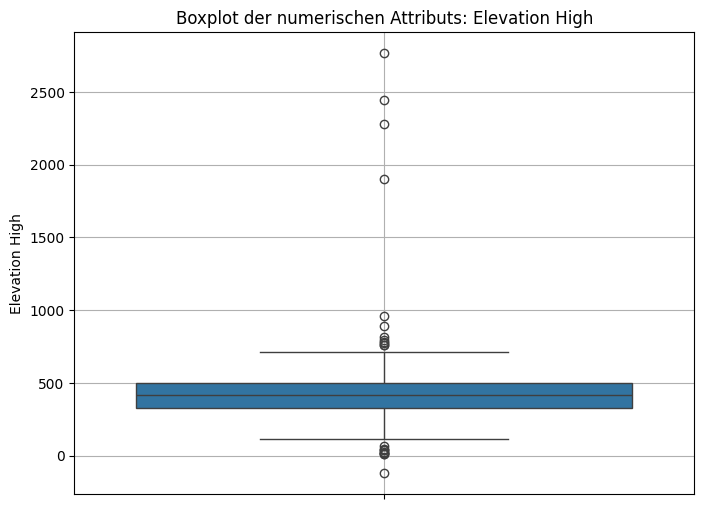

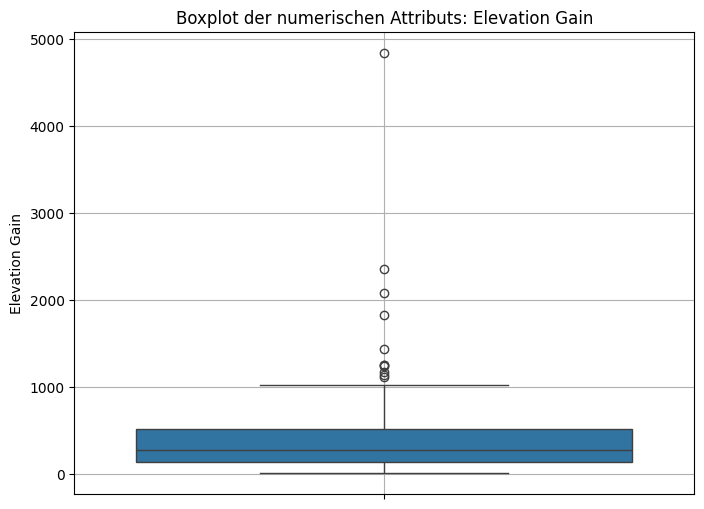

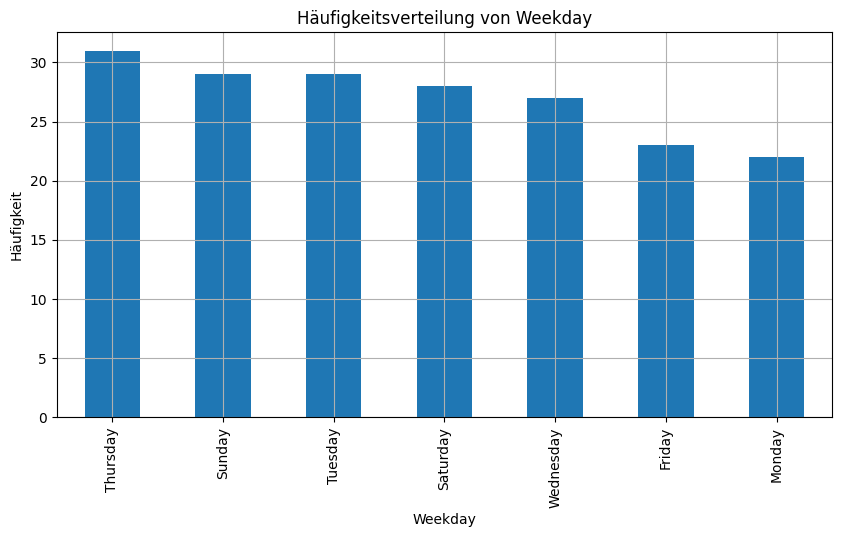

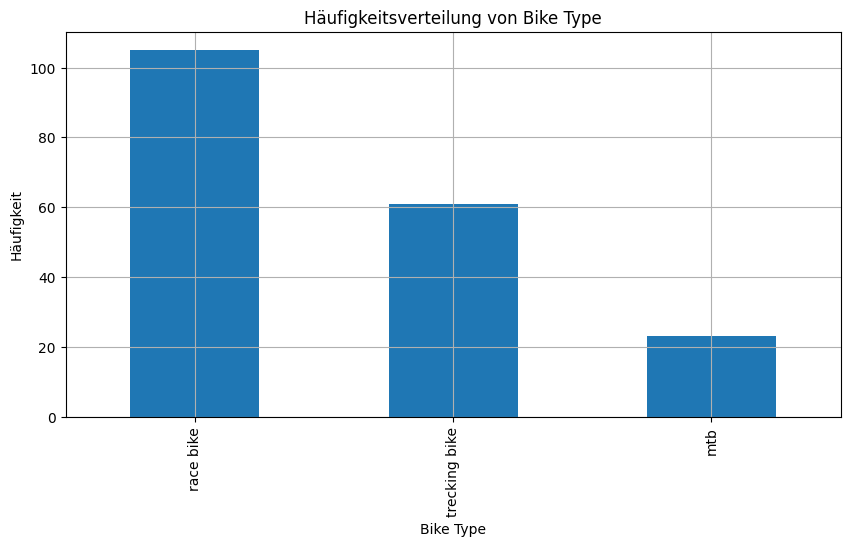

In [8]:
# Numerische Attribute - einzelne Boxplots
numeric_columns = data.select_dtypes(include='number').columns

for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot der numerischen Attributs: {column}')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

# Kategoriale Attribute - Häufigkeitsverteilungen
categorical_columns = data.select_dtypes(include='object').columns

for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    data[column].value_counts().plot(kind='bar')
    plt.title(f'Häufigkeitsverteilung von {column}')
    plt.xlabel(column)
    plt.ylabel('Häufigkeit')
    plt.grid(True)
    plt.show()

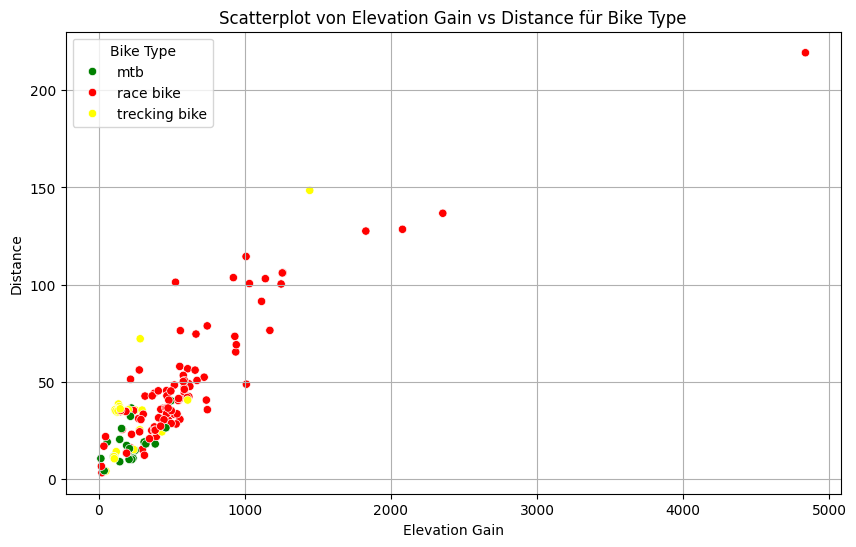

In [9]:
# Scatterplot für Elevation Gain und Distance basierend auf Bike Type

plt.figure(figsize=(10, 6))
colors = {'race bike': 'red', 'mtb': 'green', 'trecking bike': 'yellow'}
sns.scatterplot(data=data, x='Elevation Gain', y='Distance', hue='Bike Type', palette=colors)
plt.title('Scatterplot von Elevation Gain vs Distance für Bike Type')
plt.xlabel('Elevation Gain')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

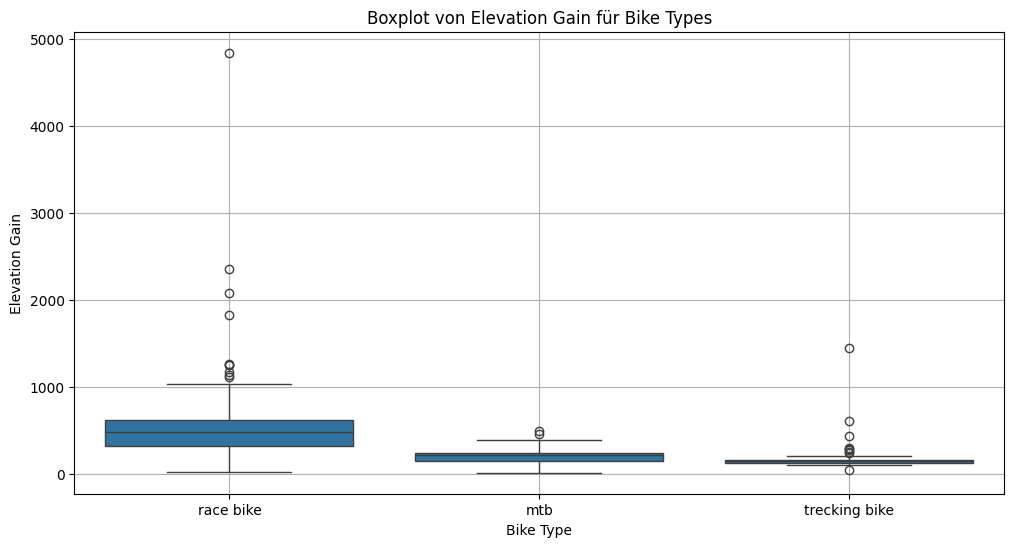

In [10]:
# Boxplot für Elevation Gain
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bike Type', y='Elevation Gain', data=data, order=['race bike', 'mtb', 'trecking bike'])
plt.title('Boxplot von Elevation Gain für Bike Types')
plt.xlabel('Bike Type')
plt.ylabel('Elevation Gain')
plt.grid(True)
plt.show()

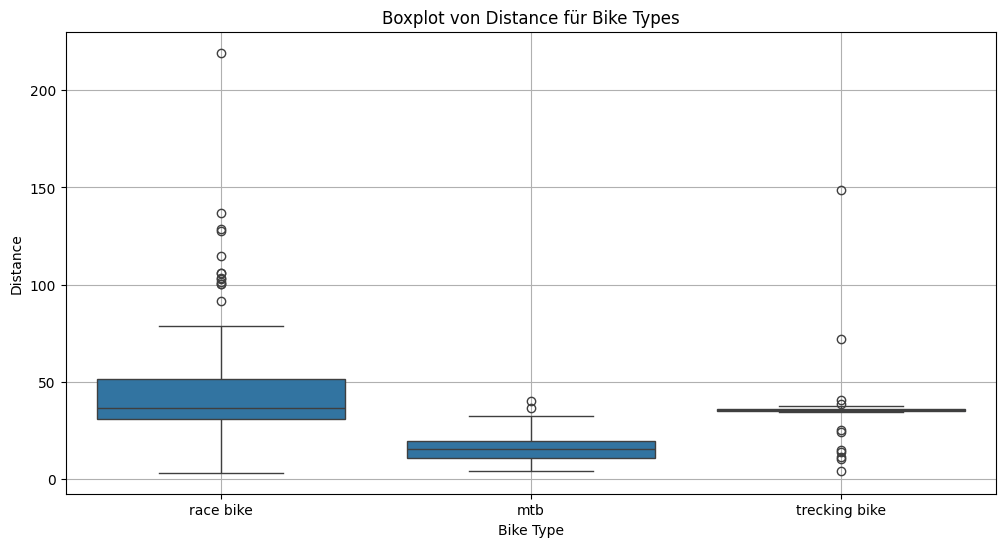

In [11]:
# Boxplot für Distance
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bike Type', y='Distance', data=data, order=['race bike', 'mtb', 'trecking bike'])
plt.title('Boxplot von Distance für Bike Types')
plt.xlabel('Bike Type')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

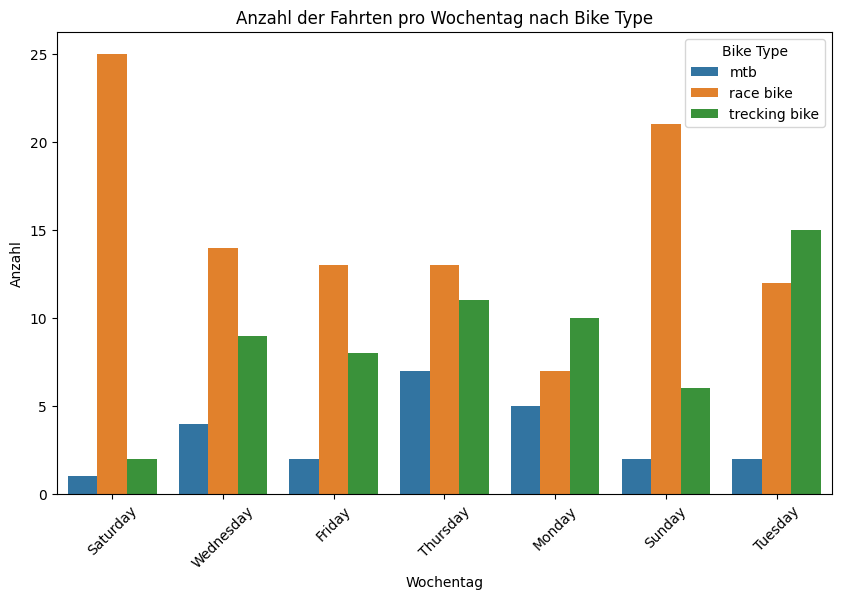

In [12]:
# Balkendiagramm: Verteilung der Bike Types über die Wochentage
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Weekday', hue='Bike Type')
plt.title('Anzahl der Fahrten pro Wochentag nach Bike Type')
plt.xlabel('Wochentag')
plt.ylabel('Anzahl')
plt.xticks(rotation=45)
plt.legend(title='Bike Type')
plt.show()

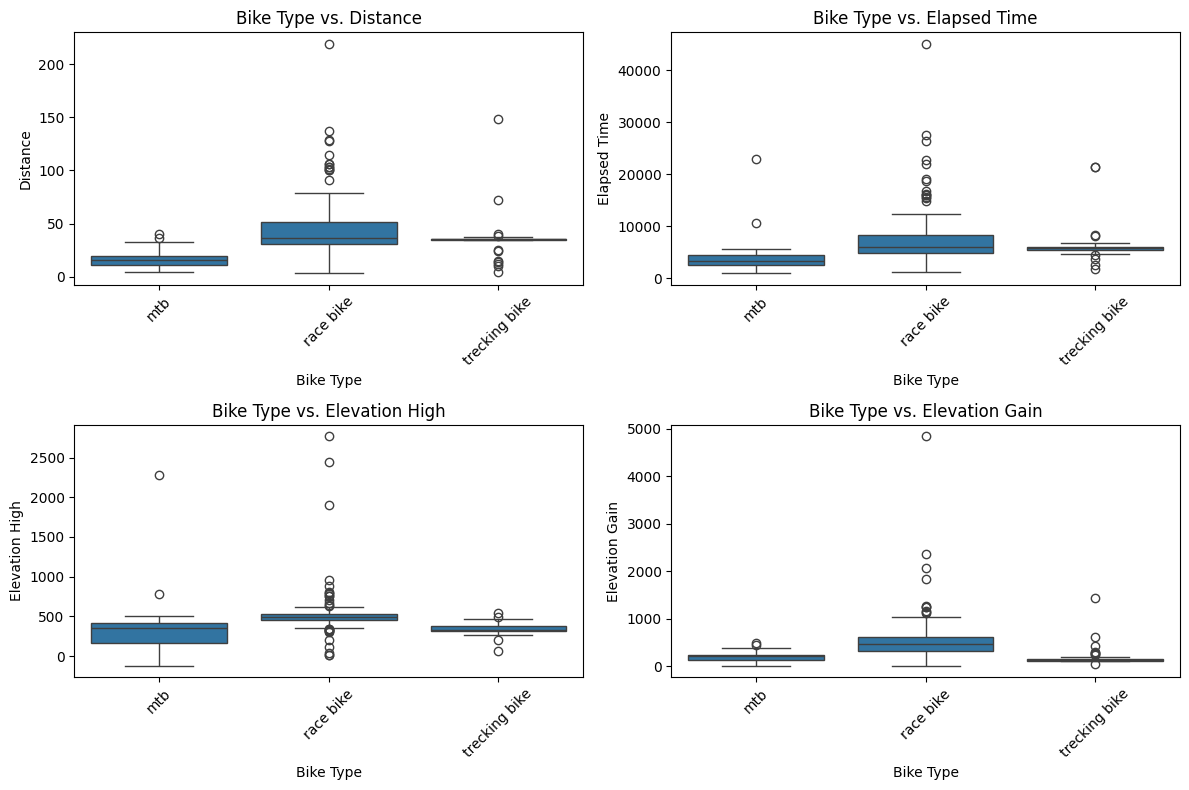

In [13]:
# Boxplots zur Analyse von Bike Type vs. Leistungswerte
plt.figure(figsize=(12, 8))
for i, col in enumerate(['Distance', 'Elapsed Time', 'Elevation High', 'Elevation Gain'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=data['Bike Type'], y=data[col])
    plt.title(f'Bike Type vs. {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

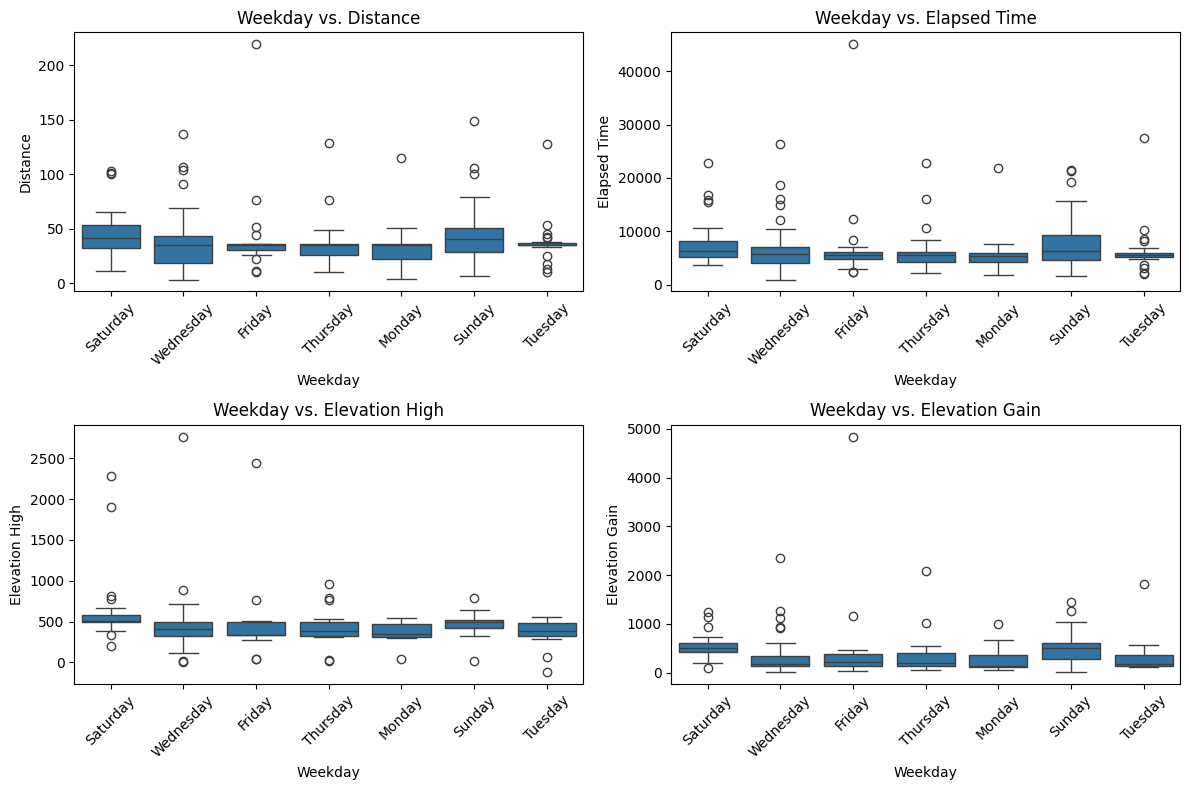

In [14]:
# Boxplots zur Analyse von Weekday vs. Leistungswerte
plt.figure(figsize=(12, 8))
for i, col in enumerate(['Distance', 'Elapsed Time', 'Elevation High', 'Elevation Gain'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=data['Weekday'], y=data[col])
    plt.title(f'Weekday vs. {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

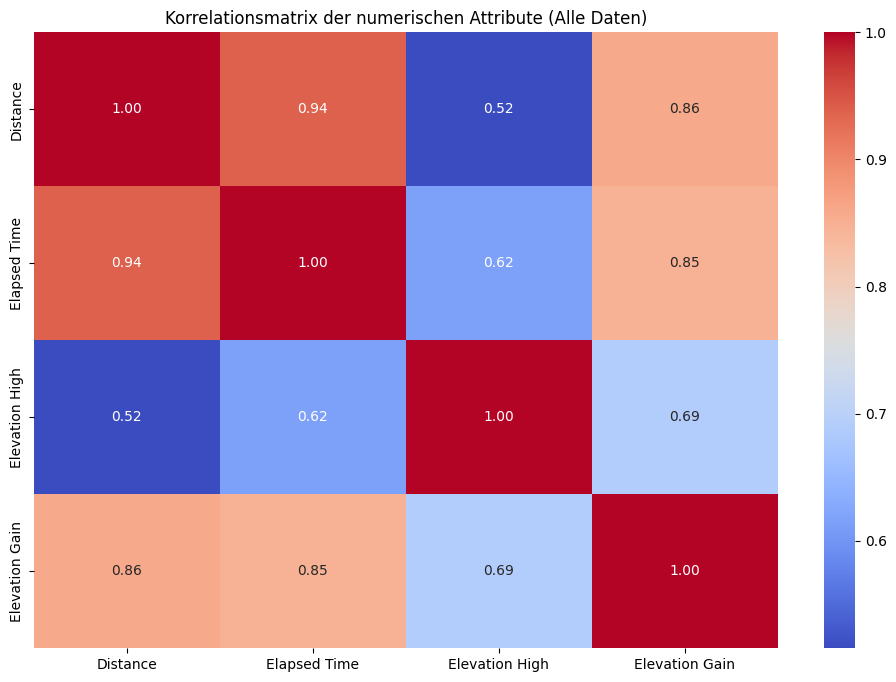

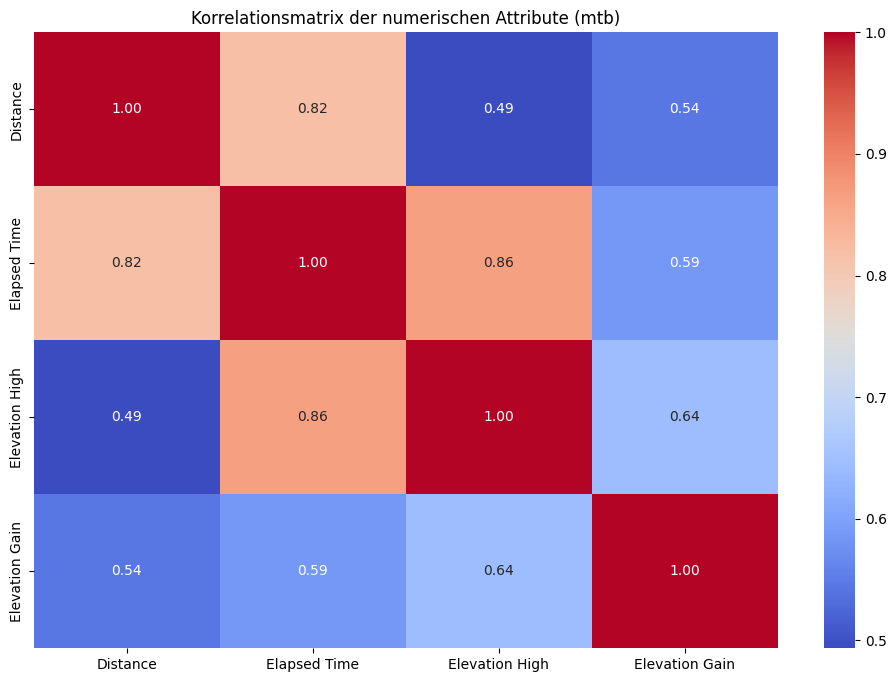

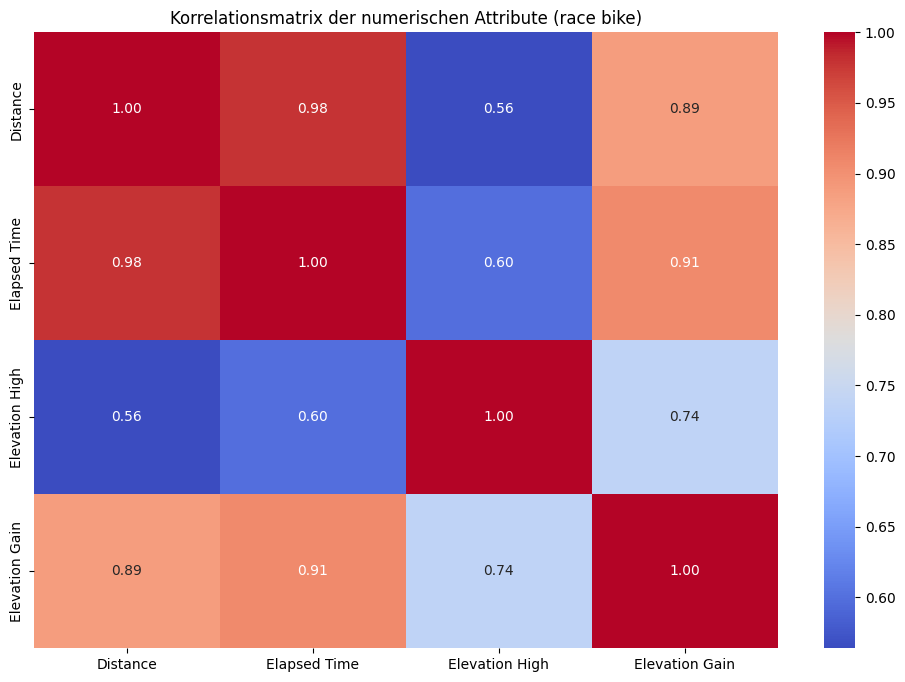

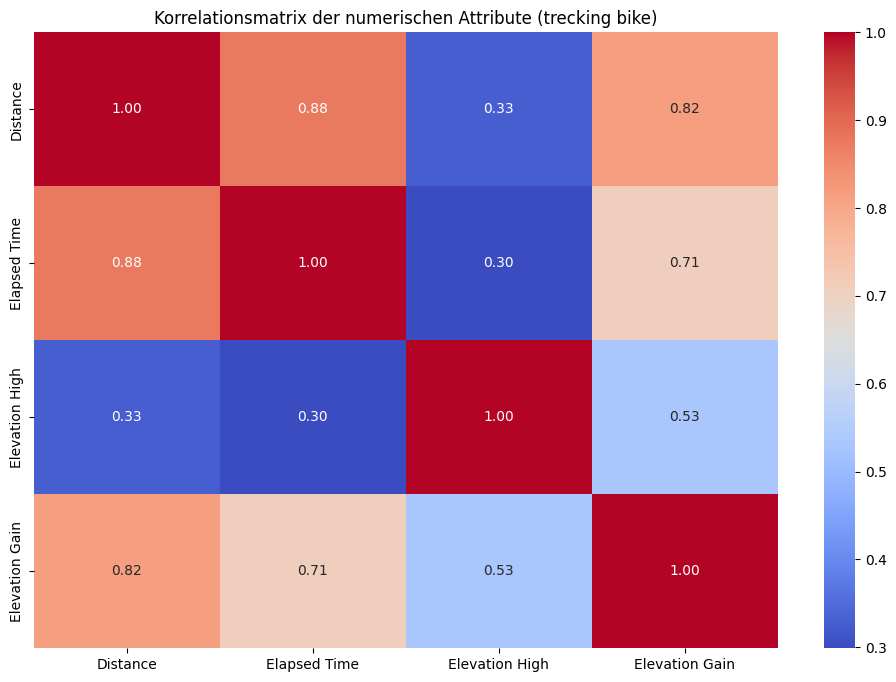

In [15]:
# Korrelationsmatrix für alle Daten berechnen und plotten
correlation_matrix = data[['Distance', 'Elapsed Time', 'Elevation High', 'Elevation Gain']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Korrelationsmatrix der numerischen Attribute (Alle Daten)')
plt.show()

# Korrelationsmatrix für jeden Bike Type berechnen und plotten
for bike_type in data['Bike Type'].unique():
    bike_data = data[data['Bike Type'] == bike_type]
    correlation_matrix = bike_data[['Distance', 'Elapsed Time', 'Elevation High', 'Elevation Gain']].corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f'Korrelationsmatrix der numerischen Attribute ({bike_type})')
    plt.show()

## Aufgabenteil 1: Bayes Netze
Entwerfen Sie ein KI Modell auf Basis der Bayes Netze und setzen Sie dieses
als Jupyter Notebook um. Insbesondere wird eine geeignete Netzarchitektur und ein
Vorschlag für eine plausible Wahrscheinlichkeitsverteilung benötigt.

In [16]:
# !pip install pgmpy 

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD


### 1. Modell anlegen

Dies enthält zunächst die (kausalen) Abhängigkeiten.

In [17]:
model = BayesianNetwork([
    ('Distance', 'Bike Type'),
    ('Elapsed Time', 'Bike Type'),
    ('Elevation High', 'Bike Type'),
    ('Elevation Gain', 'Bike Type'),
    ('Weekday', 'Bike Type'),
    ('Elapsed Time', 'Distance'),
    ('Elapsed Time', 'Elevation Gain'),
    ('Distance', 'Elevation Gain'),
])

### Begründung zum Modell

<...Ihr Text...>

### 2. CPTs anlegen

Das ist der Kern des Bayes'schen Netzes. Die CPTs können aus Daten gewonnen werden, sofern viele da sind. Ansonsten ist zusätzlich Hintergrundwissen und Schätzung zu verwenden.

In [ ]:
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator

# Fit the model using Maximum Likelihood Estimation
# Fit the model using Bayesian Estimation
model.fit(data, estimator=BayesianEstimator)

# Output the learned CPDs
for cpd in model.get_cpds():
    print("CPD von {variable}:".format(variable=cpd.variable))
    print(cpd)

C:\Users\n11we\AppData\Roaming\Python\Python311\site-packages\pgmpy\estimators\BayesianEstimator.py:214: RuntimeWarning: overflow encountered in scalar multiply
  node_cardinality * np.prod(parents_cardinalities)


In [ ]:
# Beispiel aus dem Übungslabor - ersetzen Sie dies durch eigene Berechnungen für die CPTs

import numpy as np

#logisch = 1. wahrscheinlichkeit ... wählbar.
x = 1.0

values = []

# Durchlaufe alle 32 Kombinationen der Eltern
for tra in [0, 1]:  # Traurigkeit: 0 = 'nein', 1 = 'ja'
    for ang in [0, 1]:  # Angst: 0 = 'nein', 1 = 'ja'
        for ek in [0, 1]:  # Ekel: 0 = 'nein', 1 = 'ja'
            for wu in [0, 1]:  # Wut: 0 = 'nein', 1 = 'ja'
                for fr in [0, 1]:  # Freude: 0 = 'nein', 1 = 'ja'
                    if tra == 1:  # Wenn Traurigkeit = 'ja'
                        # Wenn Traurigkeit gegeben ist, wird 'langsam' auf x und 'schnell' auf 1-x gesetzt
                        values.append([1-x, x]) 
                    else:  # Wenn Traurigkeit = 'nein'
                        # Wenn Angst, Ekel, Wut oder Freude gegeben ist, wird 'schnell' auf x und 'langsam' auf 1-x gesetzt
                        if ang == 1 or ek == 1 or wu == 1 or fr == 1:
                            values.append([x, 1-x])  # [langsam=1-x, schnell=x]
                        else:
                            values.append([0.5, 0.5])  # Unwissenheit -> beide 0.5

values = np.array(values).T

# CPD für Sprechgeschwindigkeit erstellen
cpd_Sprechgeschwindigkeit = TabularCPD(
    variable='Sprechgeschwindigkeit', variable_card=2,
    values=values,  # Wahrscheinlichkeiten für jede Kombination von Eltern
    evidence=['Traurigkeit', 'Angst', 'Ekel', 'Wut', 'Freude'],
    evidence_card=[2, 2, 2, 2, 2],
    state_names={'Sprechgeschwindigkeit':['schnell','langsam'],
                 'Angst': ['nein','ja'],
                 'Ekel': ['nein','ja'],
                 'Wut': ['nein','ja'],
                 'Freude': ['nein','ja'],
                 'Traurigkeit': ['nein','ja']
                })

model.add_cpds(cpd_Sprechgeschwindigkeit, cpd_Angst, cpd_Wut, cpd_Freude, cpd_Ekel, cpd_Traurigkeit)

model.check_model()

NameError: name 'cpd_Angst' is not defined

### Begründung zur Füllung der CPTs

<...Ihr Text...>

### 3. Inferenz

Nutzen Sie nun die Inferenz der Bayes Netze um die Klassifikation durchzuführen.


In [ ]:
# Beispielcode aus dem Übungslabor - ersetzen Sie dies durch geeigneten eigenen (umfangreicheren) Code

from pgmpy.inference import VariableElimination

infer = VariableElimination(model)

distrib = infer.query(['Angst'])
print(distrib)

### 4. Test und Bewertung 

Testen Sie die Funktionsweise Ihres Netzes und diskutieren Sie die Ergebnisse.

In [ ]:
# Ihr Code



### Diskussion der Ergebnisse 

<...Ihr Text...>

## Aufgabenteil 2: Case Based Reasoning

Entwerfen Sie ein KI Modell auf Basis von Case Based Reasoning und setzen
Sie dieses als Jupyter Notebook um. Wählen Sie geeignete Vorgehensweisen um die Fallbasis
aufzubauen (CBL) und geeignete Ähnlichkeitsmaße.

### 1. Ähnlichkeitsmaß definieren

Entwerfen Sie ein zur Aufgabenstellung passendes und geeignetes Ähnlichkeitsmaß.

In [ ]:
# Beispiel - hier soll Ihr Code eingefügt werden

def aehnlichkeit(person1, person2):
    """
    Berechnet die Ähnlichkeit zwischen zwei Personen.

    Args:
        person1: Eine Zeile des Datensatzes als Dictionary.
        person2: Eine Zeile des Datensatzes als Dictionary.

    Returns:
        float: Ein Wert zwischen 0 und 1, der die Ähnlichkeit angibt.
    """

    aehnlichkeit = 1.0

    return aehnlichkeit

### Begründung zur Wahl des Ähnlichkeitsmaßes

<...Ihr Text...>

### 2. CBR Zyklus umsetzen

Zunächst wird RETRIEVE benötigt. Dann sollte geprüft werden ob das Ergebnis bereits ausreicht. Wenn nicht, sollte geprüft werden, ob man die Daten in die Fallbasis aufnimmt. Die Fallbasis ist klein zu halten.

In [ ]:
# Beispiel aus dem Übungslabor - durch eigene Lösung zu ersetzen

def finde_aehnlichsten_fall(df, person_zu_vergleichen):
    """
    Findet die Person im DataFrame, die die größte Ähnlichkeit zur gegebenen Person hat.

    Args:
        df: Ein Pandas DataFrame mit den Personendaten.
        person_zu_vergleichen: Ein Dictionary, das die Merkmale der Person zum Vergleich enthält.

    Returns:
        tuple: Ein Tupel mit (index, ähnlichkeit), wobei index der Index der ähnlichsten Person im DataFrame und ähnlichkeit der Ähnlichkeitswert ist.
    """

    max_aehnlichkeit = -1
    index_aehlichste_person = -1

    for i, row in df.iterrows():
        person_im_df = row.to_dict()

        a = aehnlichkeit(person_zu_vergleichen, person_im_df)

        if a > max_aehnlichkeit:
            max_aehnlichkeit = a
            index_aehlichste_person = i
            aehnlichster_datensatz = row

    return index_aehlichste_person, max_aehnlichkeit, aehnlichster_datensatz

In [ ]:
# CBL umsetzen (vgl. Übungslabor)



### Begründungen 

<...Ihr Text...>

### 3. Test und Bewertung

Wie gut ist der Klassifikator? Prüfen Sie Ihre Konfiguration (u.a. abhängig von Ähnlichkeitsfunktion) und testen Sie geeignet. 

In [ ]:
# Ihr Code


### Diskussion der Ergebnisse 

<...Ihr Text...>

# Abschluss

Vergleich der beiden Verfahren. Ggf. ist hier noch Code zum Vergleich zu ergänzen, ansonsten weitgehend durch Text.

<...Ihr Text...>